In [1]:
import numpy as np
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LogNorm, SymLogNorm
from matplotlib.transforms import ScaledTranslation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cmocean

In [2]:
def label_ax(ax, label, position='top', fontsize=16):
    if position == 'inside':
        ax.annotate(
            label,
            xy=(0, 1), xycoords='axes fraction',
            xytext=(+0.5, -0.5), textcoords='offset fontsize',
            fontsize=fontsize, verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='1.', edgecolor='k', pad=3.0))
    elif position == 'top':
        ax.text(
            0.0, 1.0, label, transform=(
                ax.transAxes + ScaledTranslation(7/72, +3/72, fig.dpi_scale_trans)),
            fontsize=fontsize, va='bottom', fontfamily='sans-serif')

In [3]:
month_names = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

In [4]:
data_fold = '../final_data'
ds = xr.open_dataset(f'{data_fold}/leadtime_attrs.nc')

In [5]:
target_month = xr.concat([(m+ds['lead']-1)%12+1 for m in ds['month']], dim='month')
ds['target_month'] = target_month

In [6]:
ver_all_abs = xr.concat(
    [ds['ABS_LOG_INTENSITY_50_RATIO'].where(ds['target_month']==int(vm)) for vm in np.arange(12)+1],
    dim='target_month'
)
ver_all_abs['target_month'] = np.arange(12)+1

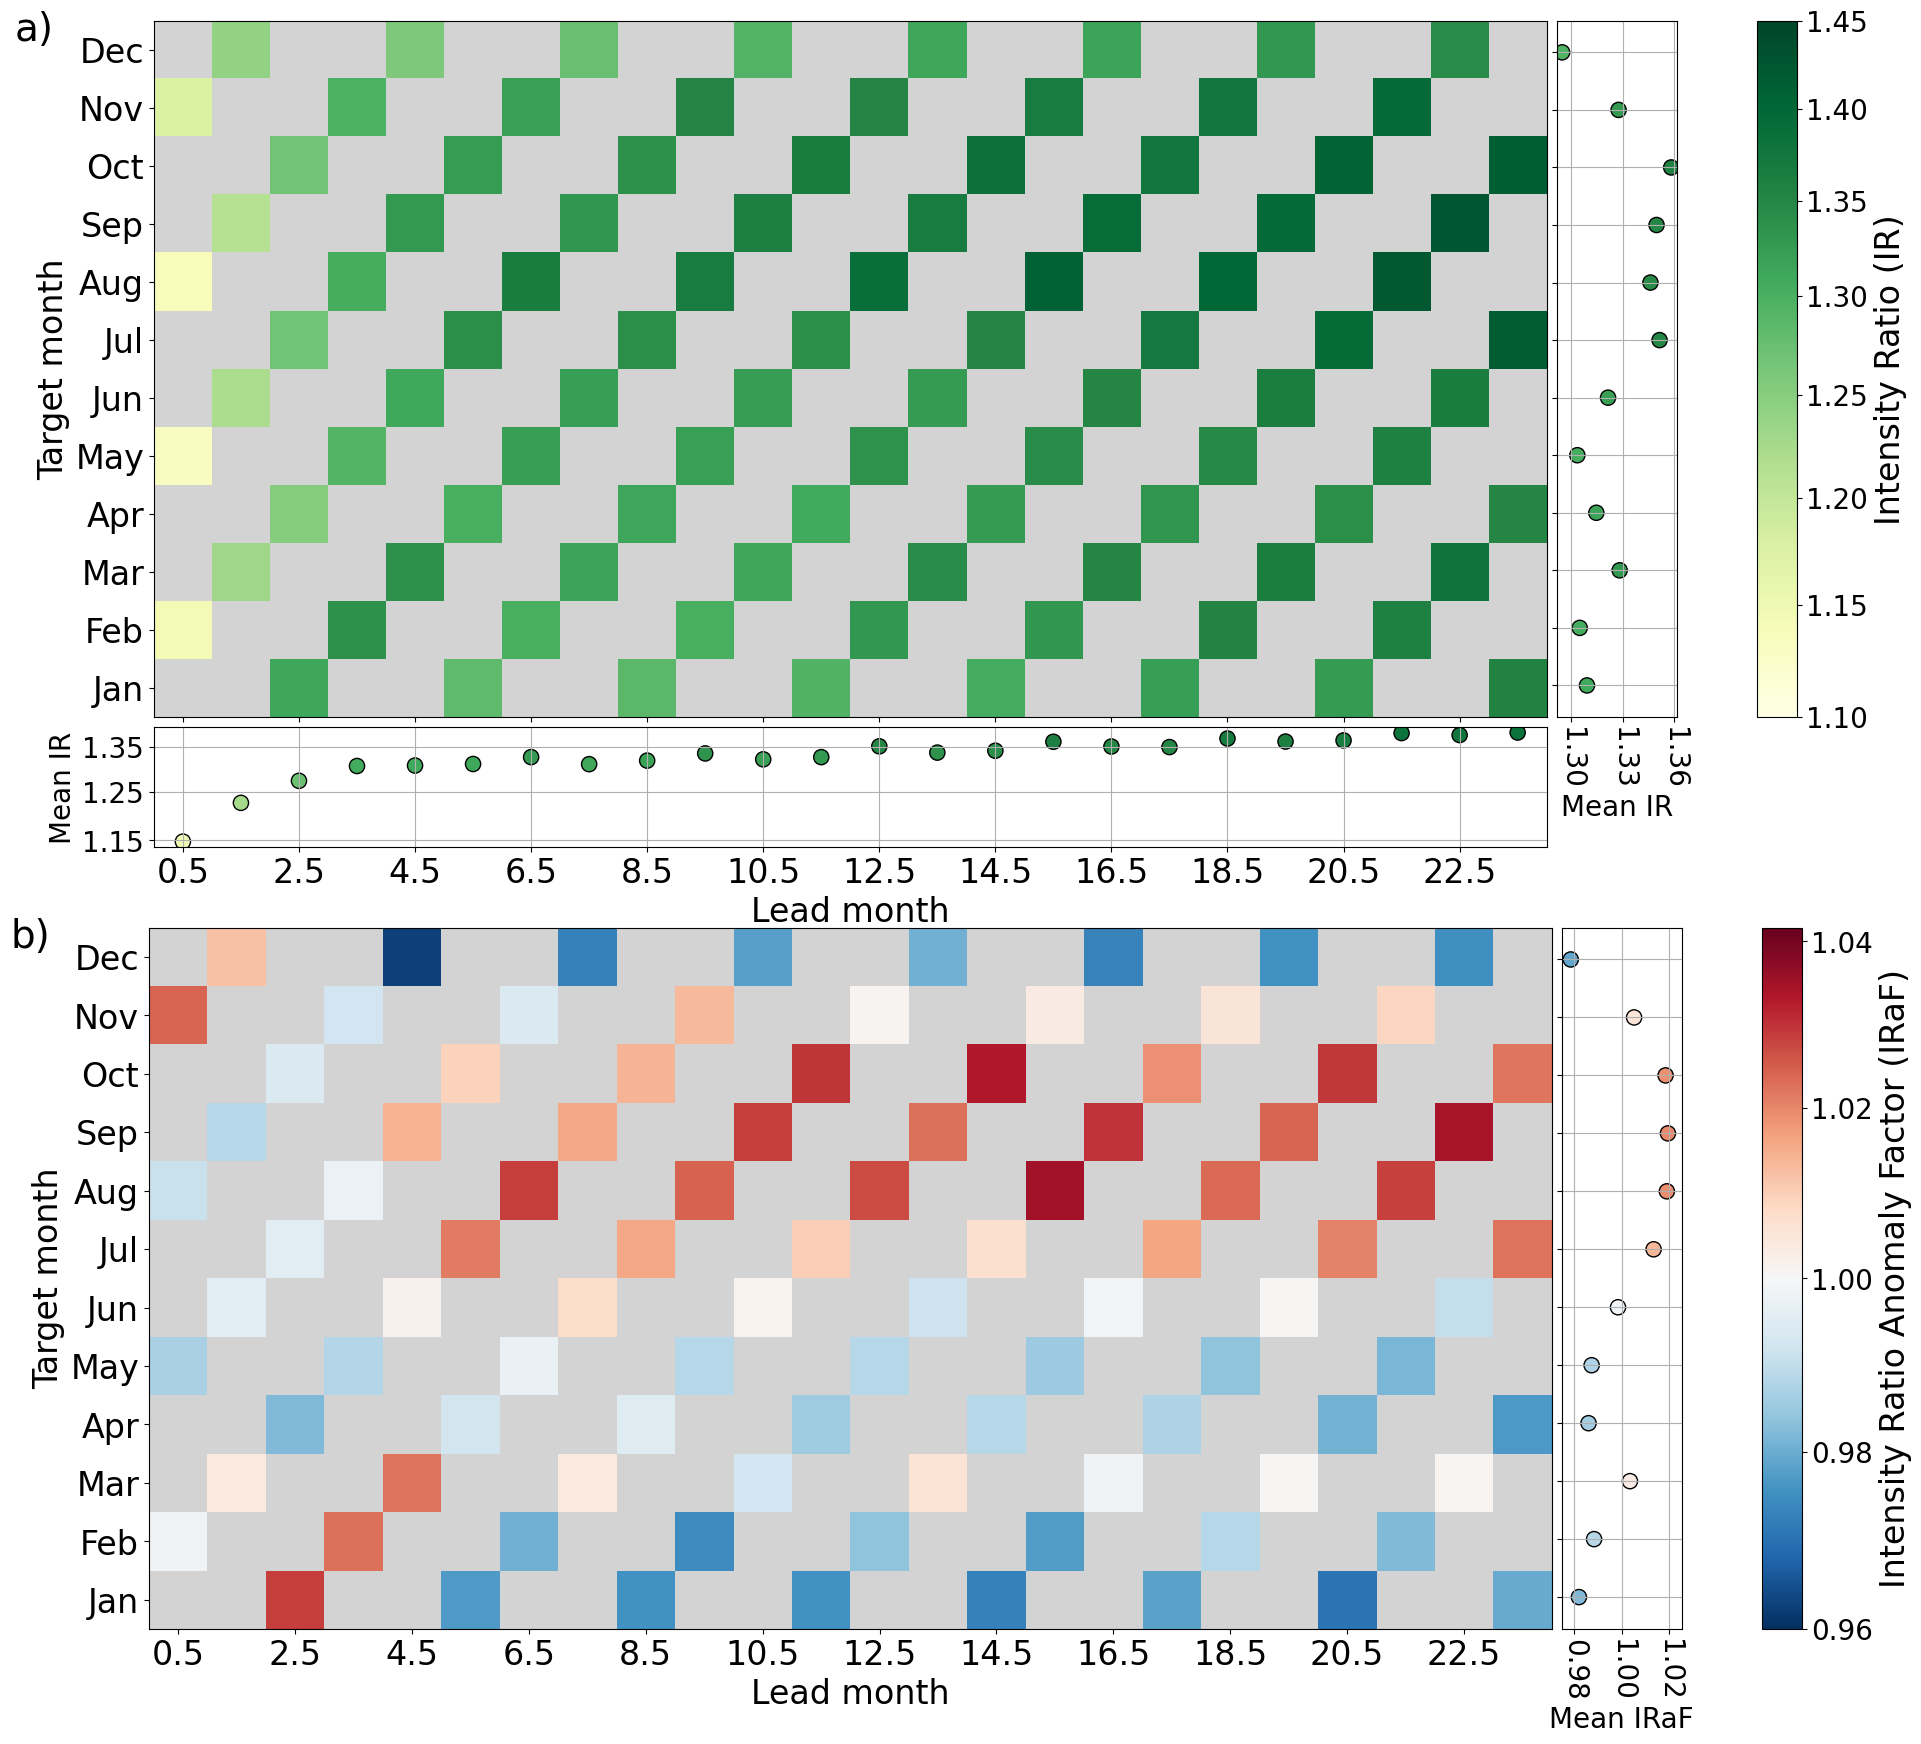

In [7]:
fontsize = 24
numsize = 20
labelsize = 28
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18, 18), layout='compressed')

# PANEL A
vmin, vmax = 1.1, 1.45
cmap = matplotlib.colormaps['YlGn']
cmap.set_bad('lightgray')
cnorm = LogNorm(vmin=vmin, vmax=vmax)
extent=[0, 24, 0, 12]

# Data
za = np.exp(ver_all_abs.mean(('month')))  # Center plot
za0 = np.exp(ver_all_abs.mean(('month', 'target_month')))  # Bottom plot
za1 = np.exp(ver_all_abs.mean(('month', 'lead')))  # Right plot

# Center plot
im = axes[0].imshow(za, cmap=cmap, extent=extent,  aspect=1, origin='lower', norm=cnorm)
axes[0].set_yticks([m+0.5 for m in range(12)],
                      labels=list(month_names.values()), rotation=0, ha="right", rotation_mode="anchor", fontsize=fontsize)
axes[0].set_ylabel('Target month', fontsize=fontsize)
divider0 = make_axes_locatable(axes[0])
ax_linex0 = divider0.append_axes("bottom", 1.2, pad=0.1, sharex=axes[0])
ax_liney0 = divider0.append_axes("right", 1.2, pad=0.1)
cax = divider0.append_axes('right', 0.4, pad=0.8)
# Right plot
im_lead = ax_liney0.scatter(za1, np.arange(12)+0.5, s=120, c=za1, cmap=cmap, norm=cnorm, edgecolors='k')
ax_liney0.set_xscale('log')
ax_liney0.minorticks_off()
ax_liney0.set_xticks([1.3, 1.33, 1.36], labels=['1.30', 1.33, 1.36], rotation=270, ha='center', rotation_mode=None, fontsize=numsize)
ax_liney0.set_xlabel('Mean IR', fontsize=numsize)
ax_liney0.set_yticks([m+0.5 for m in range(12)], labels=[])
ax_liney0.grid()
# Bottom plot
im_target = ax_linex0.scatter(np.arange(24)+0.5, za0.T, s=120, c=za0, cmap=cmap, norm=cnorm, edgecolors='k')
ax_linex0.set_yscale('log')
ax_linex0.minorticks_off()
ax_linex0.sharex(axes[0])
ax_linex0.set_yticks([1.15, 1.25, 1.35], labels=['1.15', '1.25', '1.35'], rotation=0, ha="right", rotation_mode="anchor", fontsize=numsize)
ax_linex0.set_ylabel('Mean IR', fontsize=numsize)
ax_linex0.set_xticks([l+0.5 for l in range(24)][::2], labels=[str(l+0.5) for l in range(24)][::2], rotation=0, ha='center', rotation_mode=None, fontsize=fontsize)
ax_linex0.set_xlabel('Lead month', fontsize=fontsize)
ax_linex0.grid()
# Color Bar
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Intensity Ratio (IR)', fontsize=fontsize)
cbar.ax.tick_params(labelsize=numsize)
cbar.ax.set_yticks([1.1+.05*i for i in range(8)], labels=[f'{1.1+.05*i:.2f}' for i in range(8)])
cbar.ax.minorticks_off()


# PANEL B
vmin, vmax = 0.96, 1/0.96
cmap = matplotlib.colormaps['RdBu_r']
cmap.set_bad('lightgray')
cnorm = LogNorm(vmin=vmin, vmax=vmax)
extent=[0, 24, 0, 12]

# Data
log_anomalies = ver_all_abs.mean(('month')) - ver_all_abs.mean(('month', 'target_month'))
zb = np.exp(log_anomalies)  # Equivalent to za / za0
# zb0 = np.exp(log_anomalies.mean('target_month'))  # Equals zero by definition
zb1 = np.exp(log_anomalies.mean('lead'))

# Center plot
im = axes[1].imshow(zb, cmap=cmap, extent=extent, aspect=1, origin='lower', norm=cnorm)
axes[1].sharex(axes[0])
axes[1].set_xticks([l+0.5 for l in range(24)][::2], labels=[str(l+0.5) for l in range(24)][::2], rotation=0, ha='center', rotation_mode=None, fontsize=fontsize)
axes[1].set_xlabel('Lead month', fontsize=fontsize)
axes[1].set_yticks([m+0.5 for m in range(12)],
                      labels=list(month_names.values()), rotation=0, ha="right", rotation_mode="anchor", fontsize=fontsize)
axes[1].set_ylabel('Target month', fontsize=fontsize)
divider1 = make_axes_locatable(axes[1])
ax_liney1 = divider1.append_axes("right", 1.2, pad=0.1)
cax = divider1.append_axes('right', 0.4, pad=0.8)
# Right plot
im_lead = ax_liney1.scatter(zb1, np.arange(12)+0.5, s=120, c=zb1, cmap=cmap, norm=cnorm, edgecolors='k')
ax_liney1.set_xscale('log')
ax_liney1.minorticks_off()
ax_liney1.set_xlim([0.975, 1/0.975])
ax_liney1.set_xticks([0.98, 1, 1.02], labels=['0.98', '1.00', '1.02'], rotation=270, ha='center', rotation_mode=None, fontsize=numsize)
ax_liney1.set_xlabel('Mean IRaF', fontsize=numsize)
ax_liney1.set_yticks([m+0.5 for m in range(12)], labels=[])
ax_liney1.grid()
# Color Bar
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(label='Intensity Ratio Anomaly Factor (IRaF)', fontsize=fontsize)
cbar.ax.tick_params(labelsize=numsize)
cbar.ax.set_yticks([0.96 + 0.02*i for i in range(5)], labels=[f'{0.96+.02*i:.2f}' for i in range(5)])
cbar.ax.minorticks_off()

# Label Panels
axes[0].text(0.0, 1.0, 'a)', transform=(
                axes[0].transAxes + ScaledTranslation(-100/72, -20/72, fig.dpi_scale_trans)),
            fontsize=labelsize, va='bottom', fontfamily='sans-serif')
axes[1].text(0.0, 1.0, 'b)', transform=(
                axes[1].transAxes + ScaledTranslation(-100/72, -20/72, fig.dpi_scale_trans)),
            fontsize=labelsize, va='bottom', fontfamily='sans-serif')

plt.show()